# 🕵️‍♀️ Modelagem Não Supervisionada: Clusterização de Aeroportos

**Objetivo:** Agrupar os aeroportos com base em seu perfil operacional para descobrir padrões ocultos de infraestrutura e eficiência.

**Abordagem Dupla:**
1.  **K-Means:** Para segmentar a vasta maioria dos aeroportos em perfis de negócio claros (ex: Hubs, Regionais).
2.  **DBSCAN:** Para identificar aeroportos "anômalos" ou outliers que não se encaixam no comportamento padrão da malha aérea.

In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Bibliotecas de Machine Learning
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans, DBSCAN
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics import silhouette_score

    # Configurações visuais
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    print("Ambiente configurado com sucesso.")
except Exception as e:
    print("Um erro ocorreu ao configurar o ambiente:", e)

Ambiente configurado com sucesso.


## 1. Preparação dos Dados (Agregação)

Transformando o dataset de voos em um dataset de aeroportos.

In [2]:
df = pd.read_parquet('../data/df_limpo_com_features.parquet')

if 'df' in locals():
    print("Agregando dados por Aeroporto de Origem...")
    
    df_airports = df.groupby('ORIGIN_AIRPORT').agg(
        AVG_DEPARTURE_DELAY=('DEPARTURE_DELAY', 'mean'),
        AVG_TAXI_OUT=('TAXI_OUT', 'mean'),
        AVG_CANCEL_RATE=('ROUTE_CANCEL_RATE', 'mean'),
        FLIGHT_VOLUME=('YEAR', 'count'),
        IS_REGIONAL=('IS_ORIGIN_REGIONAL_AIRPORT', 'mean')
    ).reset_index()
    
    # Filtramos aeroportos muito pequenos para reduzir ruído
    df_airports = df_airports[df_airports['FLIGHT_VOLUME'] > 100].copy()
    
    print(f"Total de Aeroportos analisados: {len(df_airports)}")
else:
    print("Por favor, carregue o dataframe 'df' primeiro.")

Agregando dados por Aeroporto de Origem...
Total de Aeroportos analisados: 532


## 2. Normalização

In [10]:
features_cluster = ['AVG_DEPARTURE_DELAY', 'AVG_TAXI_OUT', 'AVG_CANCEL_RATE', 'FLIGHT_VOLUME']
X = df_airports[features_cluster]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Dados normalizados.")

Dados normalizados.


## 3. Algoritmo 1: K-Means (Segmentação Geral)

Usamos o K-Means para criar os grupos principais de negócio.

Calculando inércia e silhouette score para k=2 a k=9...
K-Means concluído.
Silhouette Scores: 0.58, 0.37, 0.26, 0.25, 0.27, 0.26, 0.25, 0.26
Silhouette Score para k=2: 0.5758 (Quanto maior, melhor a separação)

--- Aplicando Modelo Final com K=9 ---


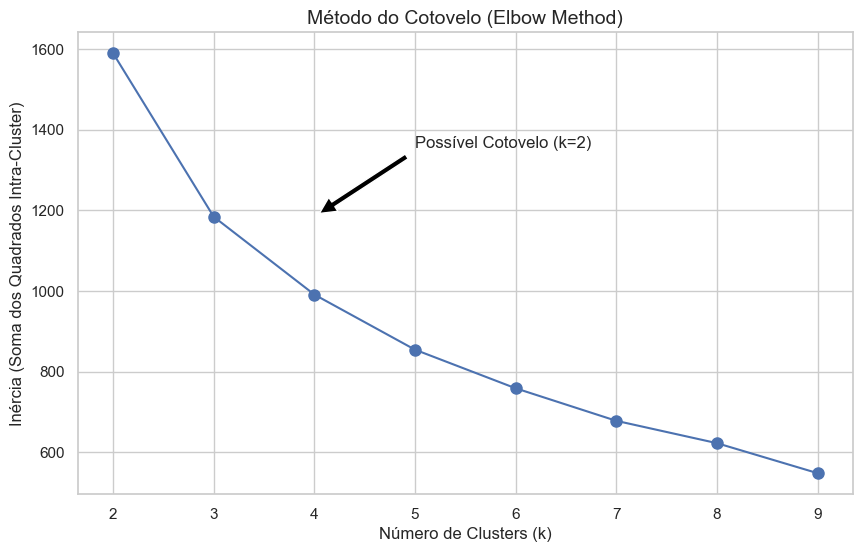

,AVG_DEPARTURE_DELAY,AVG_TAXI_OUT,AVG_CANCEL_RATE,FLIGHT_VOLUME,COUNT_AIRPORTS
CLUSTER_KMEANS,,,,,
0,-1.01 min,13.47 min,1.62%,"4,405",503
1,5.82 min,18.38 min,1.48%,"112,247",29


In [11]:
# 1. Cálculo da Inércia para diferentes K
inertia = []
scores = []
K_range = range(2, 10)
print("Calculando inércia e silhouette score para k=2 a k=9...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        score_temp = silhouette_score(X_scaled, kmeans.labels_)
        scores.append(score_temp)
    else:
        scores.append(np.nan)

# Verificação Técnica: Silhouette Score
# O Silhouette Score varia de -1 a 1.
# Valores próximos de 1 indicam que os clusters estão bem separados e densos.
idx_best_score =  scores.index(max(scores))
best_score = scores[idx_best_score]
k_optimal = K_range[idx_best_score]
print(f"K-Means concluído.")
print(f"Silhouette Scores: {', '.join(map(str, np.round(scores,2)))}")
print(f"Silhouette Score para k={k_optimal}: {best_score:.4f} (Quanto maior, melhor a separação)")

# 2. Aplicação do Modelo Final
print(f"\n--- Aplicando Modelo Final com K={k} ---")
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_airports['CLUSTER_KMEANS'] = kmeans_final.fit_predict(X_scaled)

# 3. Validação Visual (A Análise do "Cotovelo")
k = k_optimal
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia (Soma dos Quadrados Intra-Cluster)', fontsize=12)
plt.title('Método do Cotovelo (Elbow Method)', fontsize=14)
plt.grid(True)

# Adicionando uma anotação visual sugerindo onde olhar
plt.annotate(f'Possível Cotovelo (k={k})', xy=(4, inertia[k-1]), xytext=(5, inertia[3]+500),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# Médias por clusters
cluster_profile = df_airports.groupby('CLUSTER_KMEANS')[
    ['AVG_DEPARTURE_DELAY', 'AVG_TAXI_OUT', 'AVG_CANCEL_RATE', 'FLIGHT_VOLUME']
].mean()
cluster_profile['COUNT_AIRPORTS'] = df_airports['CLUSTER_KMEANS'].value_counts()
# 'YlOrRd' Yellow-Orange-Red (Amarelo = Baixo, Vermelho = Alto)
styled_table = cluster_profile.style.background_gradient(cmap='YlOrRd')\
    .format({
        'AVG_DEPARTURE_DELAY': '{:.2f} min',
        'AVG_TAXI_OUT': '{:.2f} min',
        'AVG_CANCEL_RATE': '{:.2%}',     
        'FLIGHT_VOLUME': '{:,.0f}',     
        'COUNT_AIRPORTS': '{:.0f}'
    })\
    .set_caption("**Perfil Médio por Cluster (Cores mais escuras indicam valores maiores)**")

styled_table



##### Insights: A Grande Divisão (Hubs vs. Regionais)

Os resultados do **Silhouette Score (0.58 em k=2)** indicam fortemente que a separação mais natural dos dados é **binária**. O algoritmo identificou uma dicotomia clara na infraestrutura aérea americana, dividindo os aeroportos em dois grupos distintos:

**1. Cluster 1: Os "Mega Hubs" (Gargalos de Alta Densidade)**
* **Quem são:** A elite da malha aérea. Apenas **29 aeroportos** caem nesta categoria.
* **Características:** Volume massivo de voos (média de ~112k/ano, **25x maior** que o outro grupo).
* **O Custo da Escala:** Essa densidade cobra seu preço em eficiência. Eles têm **maior tempo de táxi (18.38 min)** e uma média positiva de atrasos na partida (+5.8 min). São os pontos de congestionamento do sistema.

**2. Cluster 0: Os "Aeroportos Regionais/Locais" (Agilidade com Risco de Cancelamento)**
* **Quem são:** A vasta maioria (**503 aeroportos**).
* **Características:** Operação muito mais leve e ágil.
* **Eficiência:** Surpreendentemente pontuais, saindo em média **adiantados (-1.01 min)** e com menos tempo de pista.
* **TAXA DE CANCELAMENTO:** Apesar de serem mais pontuais, eles possuem uma **Taxa de Cancelamento ligeiramente  maior (1.62%)** que os Hubs.
    * *Hipótese de Negócio:* Voos regionais (aeronaves menores) são geralmente os primeiros a serem cancelados em condições climáticas adversas em favor de manter os voos long-haul dos Hubs.

**Conclusão para Modelagem:**
A variável `CLUSTER` (ou `IS_HUB`) será fortíssima para o modelo supervisionado. **Saber se o voo sai de um desses 29 "Mega Hubs" aumenta drasticamente a probabilidade base de atraso por congestionamento de solo (`TAXI_OUT`).**

## 4. Algoritmo 2: DBSCAN (Detecção de Anomalias)

O DBSCAN não exige que escolhamos o número de clusters. Ele agrupa por densidade. Pontos em regiões de baixa densidade são classificados como `-1` (Ruído/Outlier).

**Parâmetro Crítico (`eps`):** Define a distância máxima para dois pontos serem vizinhos. Para achar o `eps` ideal, usamos o método dos "K-Vizinhos Mais Próximos".

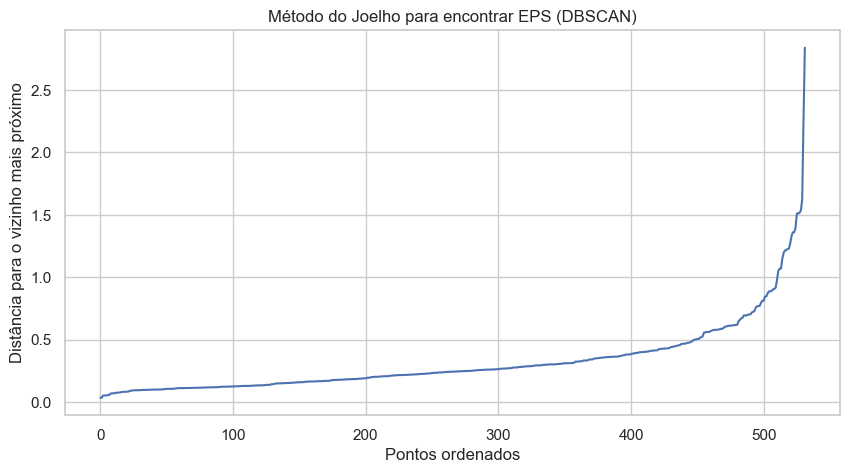

O ponto onde a curva parece subir abruptamente está entre 0.5 e 0.8.Portanto, definimos o candidato ideal para EPS como 0.75.
Geralmente está entre 0.3 e 0.8 para dados padronizados.


In [12]:
# 1. Encontrar o EPS ideal (Distância do cotovelo)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Ordenar e plotar as distâncias para encontrar o "joelho"
distances = np.sort(distances[:,1], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('Método do Joelho para encontrar EPS (DBSCAN)')
plt.ylabel('Distância para o vizinho mais próximo')
plt.xlabel('Pontos ordenados')
plt.grid(True)
plt.show()

print("O ponto onde a curva parece subir abruptamente está entre 0.5 e 0.8." \
"Portanto, definimos o candidato ideal para EPS como 0.75.")
print("Geralmente está entre 0.3 e 0.8 para dados padronizados.")

In [13]:
# 2. Aplicar DBSCAN
# min_samples: Mínimo de pontos para formar um cluster denso.

dbscan = DBSCAN(eps=0.75, min_samples=3)
df_airports['CLUSTER_DBSCAN'] = dbscan.fit_predict(X_scaled)

# Contagem
counts = df_airports['CLUSTER_DBSCAN'].value_counts()
n_outliers = counts.get(-1, 0)
n_clusters = len(counts) - (1 if -1 in counts.index else 0)

print(f"DBSCAN encontrou {n_clusters} clusters principais.")
print(f"DBSCAN detectou {n_outliers} aeroportos OUTLIERS (Cluster -1).")

DBSCAN encontrou 5 clusters principais.
DBSCAN detectou 44 aeroportos OUTLIERS (Cluster -1).


## 5. Comparativo Visual: K-Means vs DBSCAN

Vamos visualizar como cada algoritmo "enxerga" os dados.

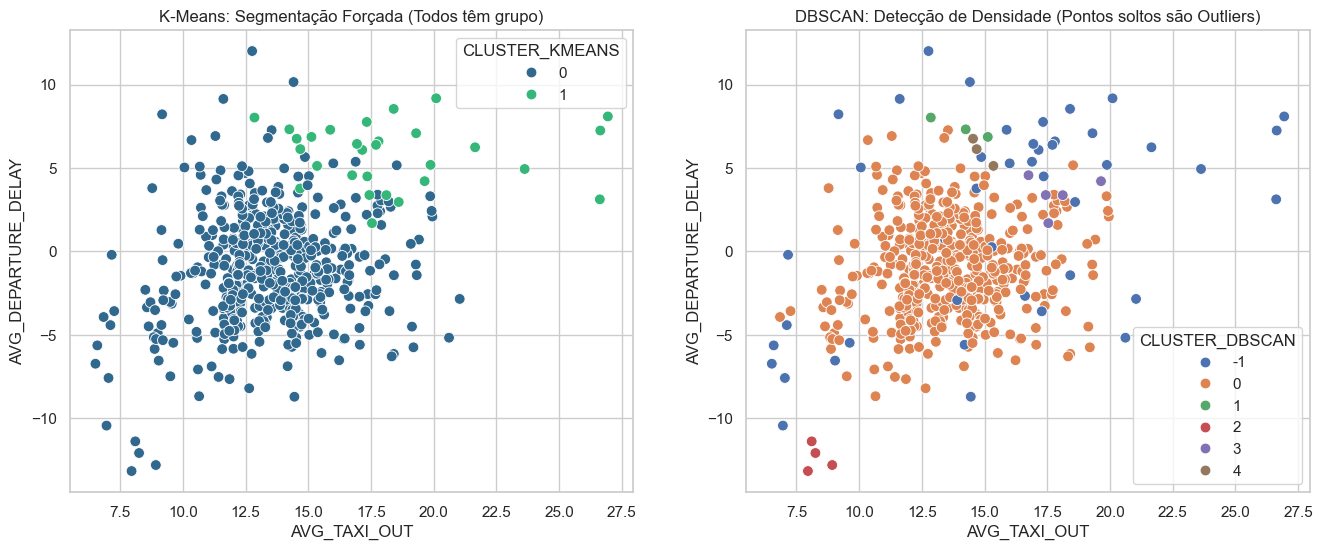

In [14]:
plt.figure(figsize=(16, 6))

# Plot K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_airports, x='AVG_TAXI_OUT', y='AVG_DEPARTURE_DELAY', 
                hue='CLUSTER_KMEANS', palette='viridis', s=60)
plt.title('K-Means: Segmentação Forçada (Todos têm grupo)')

# Plot DBSCAN
plt.subplot(1, 2, 2)
# Destacamos os outliers (-1) em vermelho
palette_dbscan = sns.color_palette('viridis', as_cmap=True)
# Truque para plotar -1 com cor distinta se usar hue numérico
sns.scatterplot(data=df_airports, x='AVG_TAXI_OUT', y='AVG_DEPARTURE_DELAY', 
                hue='CLUSTER_DBSCAN', palette='deep', s=60)
plt.title('DBSCAN: Detecção de Densidade (Pontos soltos são Outliers)')

plt.show()

## 6. Análise dos Outliers (Quem o DBSCAN rejeitou?)

Estes são os aeroportos mais interessantes para análise de falhas operacionais.

In [15]:
if 'df_airports' in locals():
    print("--- Média da de todos os Dados ---")
    features = ['ORIGIN_AIRPORT', 'AVG_DEPARTURE_DELAY', 'AVG_TAXI_OUT', 'FLIGHT_VOLUME']
    print(df_airports[features].describe().iloc[1,:])
    outliers = df_airports[df_airports['CLUSTER_DBSCAN'] == -1]
    
    print("\n--- Top 10 Aeroportos Anômalos (DBSCAN Cluster -1) ---")
    # Ordenar por atraso para ver os piores casos
    print(outliers[features].sort_values(by='AVG_DEPARTURE_DELAY', ascending=False).head(10))
    
    # Salvar resultado final
    df_airports.to_csv('airports_clusters_kmeans_dbscan.csv', index=False)
    print("\nDados salvos em 'airports_clusters_kmeans_dbscan.csv'.")

--- Média da de todos os Dados ---
AVG_DEPARTURE_DELAY       -0.637579
AVG_TAXI_OUT              13.733477
FLIGHT_VOLUME          10283.716165
Name: mean, dtype: float64

--- Top 10 Aeroportos Anômalos (DBSCAN Cluster -1) ---
    ORIGIN_AIRPORT  AVG_DEPARTURE_DELAY  AVG_TAXI_OUT  FLIGHT_VOLUME
443            GUM            12.009119     12.762918            329
540            PBG            10.152727     14.414545            275
412            EWR             9.177793     20.100324          95251
348            BQN             9.140045     11.616200           1321
509            MIA             8.542986     18.406118          66429
619            UST             8.218978      9.175182            137
472            JFK             8.091047     26.943690          89185
455            IAD             7.761257     17.332822          32579
391            DEN             7.293558     15.877087         186522
488            LGA             7.247898     26.643379          91223

Dados salvos e

#### Análise de Anomalias (DBSCAN): Onde a Operação Colapsa

O DBSCAN isolou o **Cluster -1 (Outliers)**. Enquanto a média global do sistema mostra um cenário otimista (voos saindo adiantados em **-0.63 min** e táxi de **13.7 min**), os aeroportos isolados revelam gargalos estruturais graves:

**1. O "Triângulo do Congestionamento" (Nova York - JFK, LGA, EWR)**
* O algoritmo isolou os três principais aeroportos da área de Nova York/New Jersey.
* **O Motivo:** O Tempo de Táxi (`AVG_TAXI_OUT`) é exorbitante. **JFK (26.9 min)** e **LGA (26.6 min)** têm praticamente o **dobro** da média nacional.
* *Insight:* Em JFK, um voo gasta quase meia hora só para sair do chão. Isso "mata" qualquer planejamento de conexão curta.

**2. Isolamento Geográfico e Logístico (GUM, BQN)**
* **GUM (Guam) e BQN (Porto Rico)** aparecem no topo da lista de atrasos (`AVG_DEPARTURE_DELAY` > 9 min).
* **O Motivo:** Diferente dos hubs continentais, estes aeroportos  sofrem com logística complexa. Se um voo chega atrasado, não há aeronave reserva ou tripulação extra fácil de alocar, gerando atrasos em cascata irrecuperáveis.

**3. O "Gigante Atrasado" (DEN - Denver)**
* Denver é um outlier curioso: tem o maior volume (**186k voos**), mas uma performance de atraso ruim (**7.29 min**). Provavelmente isolado devido à sua combinação única de escala massiva e alta incidência de problemas climáticos (neve/gelo) que afetam a operação de forma distinta de hubs mais ao sul como Atlanta ou Dallas.